In [1]:
'''
Author: Ivan Gvozdanovic
Date: 10/02/2024
Description:
    GAE A2C algorithm for solving the TSP using Markov Basis.
    
    
     Define a probabilit distribution over all possible combinations of coefficients for a small problem and see whether the policy
       has equal probabilities for different actions. 
''';

In [2]:
'''
Good reading material: 

    https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/03-actor-critic.ipynb
    https://github.com/Lucasc-99/Actor-Critic/blob/master/src/a2c.py
    https://github.com/pytorch/examples/blob/main/reinforcement_learning/actor_critic.py
    https://github.com/Francesco-Sovrano/Framework-for-Actor-Critic-deep-reinforcement-learning-algorithms
    https://github.com/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb
    
    https://www.reddit.com/r/reinforcementlearning/comments/aux7a5/question_about_nstep_learning_with_dqn/
    https://datascience.stackexchange.com/questions/46245/off-policy-n-step-learning-with-dqn/46260#46260
    https://people.cs.umass.edu/~barto/courses/cs687/Chapter%207.pdf
    https://arxiv.org/pdf/1606.02647
    https://arxiv.org/abs/1901.07510
''';

In [23]:
import numpy as np
import os
import networkx as nx
import itertools
from collections import deque
import time as Time
import torch
from collections import namedtuple
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from itertools import product

from DeepFiberSamplingENV_Test import PolytopeENV as Env 

In [24]:
from reward_functions import reward_cost, calculate_reward1, calculate_reward2, calculate_reward3

In [25]:
from helper_functions import create_fiber_sampling_erdos_renyi_graph, \
                             extract_distance_matrix, \
                             create_real_data_graph, \
                             create_real_data_initial_sol,\
                             moving_average, \
                             create_state_graph, \
                             permute_moves


# path_initial = os.getcwd() + os.sep + 'Real Data' + os.sep + 'LargestComponent' + os.sep + 'largeComponentMtx.txt'
path_initial = os.getcwd() + os.sep + 'Real Data' + os.sep + 'MediumComponent' + os.sep + 'nextComponentMtx.txt'

initial_states = {} # dictionary holding the initial states.
patches = 1
node_num = 4
p = 0.7
graph_num = 1

#Pick the file to the problem:
file = 'A2C_Fiber_Sampling_'


available_actions, initial_states, reward_list = \
                        create_fiber_sampling_erdos_renyi_graph(file, initial_states, node_num, p, graph_num, 1, 50)
# initial_states, available_actions, node_num = create_real_data_graph(path_initial) # works for smaller problems where we can compute lattice.


# # print(available_actions)
print(initial_states)
combinations = list(product([-1, 0, 1], repeat=len(available_actions)))
print(combinations)

all_actions = []
for comb in combinations:
    action = [np.multiply(comb[i], available_actions[i]) for i in range(len(comb))]
    action = np.stack(action)
    action = np.sum(action, 0)
    all_actions.append(action)


for m in range(len(all_actions)):
    print(all_actions[m])


{(0, 1): 24, (0, 2): 21, (0, 3): 29, (1, 2): 7, (1, 3): 34, (2, 3): 38}
Edges for reward list:  [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
Initial solution: 
 6 [0 1 1 0 0 1]
Sufficient statistic: 
 [2. 0. 2. 2.]
Number of actions is 2
{0: array([0, 1, 1, 0, 0, 1], dtype=int32)}
[(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]
[-1 -1  2  2 -1 -1]
[ 0 -1  1  1 -1  0]
[ 1 -1  0  0 -1  1]
[-1  0  1  1  0 -1]
[0 0 0 0 0 0]
[ 1  0 -1 -1  0  1]
[-1  1  0  0  1 -1]
[ 0  1 -1 -1  1  0]
[ 1  1 -2 -2  1  1]


In [26]:
save_data = True  # save Q table data and cost vector data.
save_plots = False  # save the plots
save_data_rate = 20



# Example usage for running episodes
num_episodes = 500
max_path_length = 100



n_step = max_path_length
sheduler_lr_update = 10 # every 10 trainig periods we modify the step size
gamma = 0.9
lam = 0.5
discount_factor = gamma
entropy_param = 0.1

actor_target_lr = 0.00001
critic_target_lr = 0.000001  # Set a lower target for faster convergence

actor_lr = 0.00006
critic_lr = 0.00003
step_size = num_episodes//sheduler_lr_update
lr_actor_gamma = (actor_target_lr / actor_lr) ** (1 / sheduler_lr_update)
lr_critic_gamma = (critic_target_lr / critic_lr) ** (1 / sheduler_lr_update)
print(step_size)
print(lr_actor_gamma)
print(lr_critic_gamma)



lb = -1
ub = 2



mask_size = 9
mask_rate = 50
mask_action_size = [len(all_actions)//mask_size for i in range(mask_size)]
mask_action_size[-1] += len(available_actions)%mask_size # add the remained if not divisible.
mask_range = mask_action_size[0]
print(mask_action_size)
action_space_values = [ [i+lb for i in range(ub-lb)] for j in range(len(available_actions)) ]
action_space_size = [len(all_actions)] #ub-lb for i in range(len(available_actions))
print(len(action_space_size))

50
0.8359588020779369
0.7116851017915987
[1, 1, 1, 1, 1, 1, 1, 1, 3]
1


In [27]:
from A2C_Test import Policy, \
                TransformerPolicy, \
                select_action, \
                select_action_transformer, \
                run_n_step_with_gae, \
                select_best_action, \
                select_best_action_transformer, \
                freeze_parameters, \
                generate_mask,\
                construct_stochastic_policy


feature_net_arch = [len(initial_states[0]), 56, 28, 12, 28]
# model = Policy(feature_net_arch, len(initial_states[0]), len(action_space_values))
model = TransformerPolicy(len(initial_states[0]), action_space_size, mask_action_size, mask_rate)
print(model)

optimizer = torch.optim.Adam([
    {'params': model.transformer_encoder.parameters()},   # Shared feature extractor
    {'params': model.action_heads.parameters(), 'lr': actor_lr},  # Actor-specific parameters
    {'params': model.value_head.parameters(), 'lr': critic_lr} # Critic-specific parameters
])

scheduler_actor = StepLR(optimizer, step_size=step_size, gamma=lr_actor_gamma)
scheduler_critic = StepLR(optimizer, step_size=step_size, gamma=lr_critic_gamma)


# actor_params = list(model.action_head.parameters()) + list(model.feature_net.parameters())  # Actor network params
# critic_params = list(model.value_head.parameters())  # Critic network params
# actor_optimizer = torch.optim.Adam(actor_params, lr=actor_lr)  # Learning rate for actor
# critic_optimizer = torch.optim.Adam(critic_params, lr=critic_lr)  # Learning rate for critic
eps = np.finfo(np.float32).eps.item()
SavedAction = namedtuple('SavedAction', ['log_probs', 'value', 'probs', 'mask_log_probs'])

TransformerPolicy(
  (embedding): Linear(in_features=6, out_features=16, bias=True)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=16, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (action_heads): ModuleList(
    (0): Linear(in_features=16, out_features=9, bias=True)
  )
  (mask_heads): Modu

In [28]:
# Convert dictionary values to a list of arrays
visited_states = [np.array(initial_states[0])]
visited_states = np.stack(visited_states)

#Initialize the environment.
env = Env(initial_states, # initial_state
         num_episodes, # total_episodes
         50, # show_path_num
         visited_states,  # visited_states
         all_actions, # basis_moves
         node_num, # node_num
         0, # P
         lb, #lb
         )



In [29]:
cumm_running_reward = 0
episode_reward_list = []
cumm_running_reward_list = []
loss_list = []
actor_lr_list = []
critic_lr_list = []
robins_monro_condition = []


start_time = Time.time()
iteration = 0


# run infinitely many episodes
for i_episode in range(num_episodes):

    # reset environment and episode reward
    state = env.reset()
    ep_reward = 0

    # for each episode, only run 9999 steps so that we don't
    # infinite loop while learning
    for t in range(max_path_length):


        # select action from policy
#         action = select_action(model, state, SavedAction, action_space_values, False)
        action = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, iteration, False, False)

        
        # take the action
        state, reward, done, _ = env.step(action)
        
        model.rewards.append(reward)
        ep_reward += (discount_factor**t)*reward
        cumm_running_reward += reward
        cumm_running_reward_list.append(reward)
        # perform backprop
        actor_lr,critic_lr = run_n_step_with_gae(model, n_step, gamma, lam, optimizer, scheduler_actor, scheduler_critic, lr_actor_gamma, lr_critic_gamma, entropy_param, done)
        if actor_lr != None and critic_lr != None:
            actor_lr_list.append(actor_lr)
            critic_lr_list.append(critic_lr)
            robins_monro_condition.append(critic_lr/actor_lr)
        if done:
            break
        
        iteration += 1
        
    if (i_episode + 1) % save_data_rate == 0:
        torch.save(model.state_dict(), 'Models/policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')
        end_time = Time.time()
        print(f'It took {(end_time-start_time)/60} minutes to run {i_episode} episodes.')
        
    episode_reward_list.append(ep_reward)
    
torch.save(model.state_dict(), 'Models/policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')


end_time = Time.time()
print(f'It took {(end_time-start_time)/60} minutes to run {num_episodes} episodes.')

Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Episode: 1 ||| Reward: -483.6548875629 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action co

Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Episode: 18 ||| Reward: -409.42994281855783 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Episode: 19 ||| Reward: -382.77048055711833 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Episode: 20 ||| Reward: -399.3748574249163 ||| Discovered States: 1
It took 0.41628093719482423 minutes to run 19 episodes.
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Episode: 21 ||| Reward: -374.602115189659 ||| Discovered States: 1
Action is a zer

Episode: 67 ||| Reward: -347.89044176007314 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 68 ||| Reward: -340.05207672388246 ||| Discovered States: 1
Episode: 69 ||| Reward: -342.38336244786916 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Episode: 70 ||| Reward: -369.3834667431306 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 71 ||| Reward: -354.39816376863604 ||| Discovered States: 1
Episode: 72 ||| Reward: -338.45378756337567 ||| Discovered States: 1
Episode: 73 ||| Reward: -344.94072483914215 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Episode: 74 ||| Reward: -370.3841094394898 ||| Discovered States: 1
Episode: 75 ||| Reward: -333.2143543840507 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Episode: 76 |

Action is a zero vector! Action coeffs: 
Episode: 132 ||| Reward: -351.1078048138833 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 133 ||| Reward: -349.13794585651493 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Episode: 134 ||| Reward: -355.6350261625247 ||| Discovered States: 1
Episode: 135 ||| Reward: -343.6516512771074 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 136 ||| Reward: -358.3069539203332 ||| Discovered States: 1
Episode: 137 ||| Reward: -330.5946377943884 ||| Discovered States: 1
Episode: 138 ||| Reward: -330.5946377943884 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 139 ||| Reward: -355.6872373306708 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 140 ||| Reward: -353.0675207

Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Episode: 204 ||| Reward: -335.1426438758263 ||| Discovered States: 1
Episode: 205 ||| Reward: -335.8132862409166 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Episode: 206 ||| Reward: -339.0514340275233 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 207 ||| Reward: -333.52356998252293 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 208 ||| Reward: -326.9950632411633 ||| Discovered States: 1
Episode: 209 ||| Reward: -327.9957059375225 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 210 ||| Reward: -337.45314486701653 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 211 ||| Reward: -328.284136803198 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 212 ||| Reward: -334.83342827735413 ||| Discovered States: 1
Episode:

Action is a zero vector! Action coeffs: 
Episode: 283 ||| Reward: -335.12185914302967 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 284 ||| Reward: -330.9038533928605 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 285 ||| Reward: -334.8126435445577 ||| Discovered States: 1
Episode: 286 ||| Reward: -330.5738530615918 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 287 ||| Reward: -336.12250183938886 ||| Discovered States: 1
Episode: 288 ||| Reward: -335.7925015081202 ||| Discovered States: 1
Episode: 289 ||| Reward: -324.06613105302887 ||| Discovered States: 1
Episode: 290 ||| Reward: -327.97492120472594 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Episode: 291 ||| Reward: -335.1218591430298 ||| Discovered States: 1
Episode: 292 ||| Reward: -318.8474826065005 ||| Discovered States: 1
Episode: 293 ||| Reward: -322.77705749099414 ||| Discovered 

Episode: 377 ||| Reward: -320.1365561685352 ||| Discovered States: 1
Episode: 378 ||| Reward: -333.1935696512543 ||| Discovered States: 1
Episode: 379 ||| Reward: -331.8837113564231 ||| Discovered States: 1
Episode: 380 ||| Reward: -326.66506290989474 ||| Discovered States: 1
It took 7.293447323640188 minutes to run 379 episodes.
Episode: 381 ||| Reward: -325.3552046150635 ||| Discovered States: 1
Episode: 382 ||| Reward: -324.06613105302876 ||| Discovered States: 1
Episode: 383 ||| Reward: -333.1727849184578 ||| Discovered States: 1
Episode: 384 ||| Reward: -318.8474826065005 ||| Discovered States: 1
Episode: 385 ||| Reward: -320.1573409013317 ||| Discovered States: 1
Episode: 386 ||| Reward: -331.8837113564231 ||| Discovered States: 1
Episode: 387 ||| Reward: -331.883711356423 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 388 ||| Reward: -330.90385339286047 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 389 ||| Reward: -325.685

Episode: 474 ||| Reward: -320.13655616853515 ||| Discovered States: 1
Episode: 475 ||| Reward: -325.3552046150635 ||| Discovered States: 1
Episode: 476 ||| Reward: -330.59463779438835 ||| Discovered States: 1
Episode: 477 ||| Reward: -322.7770574909941 ||| Discovered States: 1
Episode: 478 ||| Reward: -318.8474826065005 ||| Discovered States: 1
Episode: 479 ||| Reward: -324.0661310530288 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Episode: 480 ||| Reward: -341.6295811515928 ||| Discovered States: 1
It took 9.18897670507431 minutes to run 479 episodes.
Episode: 481 ||| Reward: -316.2277660168381 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 482 ||| Reward: -324.375346651501 ||| Discovered States: 1
Episode: 483 ||| Reward: -317.5376243116693 ||| Discovered States: 1
Episode: 484 ||| Reward: -320.1573409013317 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 485 ||| Rewar

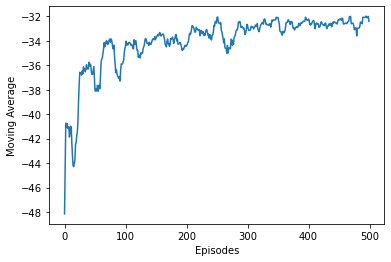

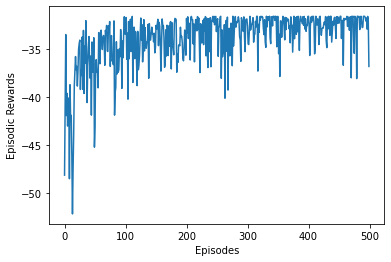

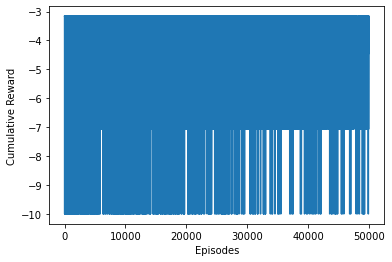

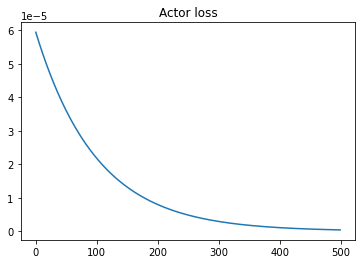

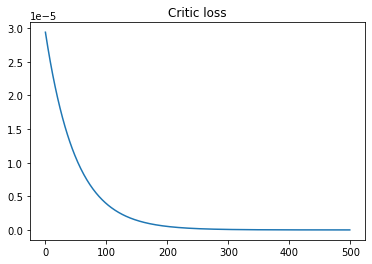

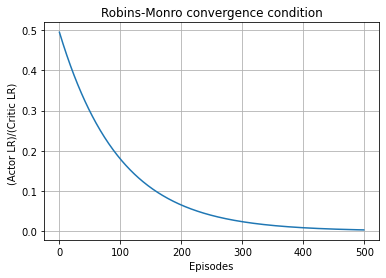

In [30]:
cum_reward_x_axis = [i for i in range(len(cumm_running_reward_list))]
ep_reward_x_axis = [i for i in range(len(episode_reward_list))]
loss_x_axis = [i for i in range(len(loss_list))]
actor_lr_x_axis = [i for i in range(len(actor_lr_list))]
critic_lr_x_axis = [i for i in range(len(critic_lr_list))]

smoothed_rewards = moving_average(episode_reward_list, 10)
smoothed_rewards_x_axis = [i for i in range(len(smoothed_rewards))]

plt.plot(smoothed_rewards_x_axis, smoothed_rewards)
plt.xlabel("Episodes")
plt.ylabel("Moving Average")
plt.show()

plt.plot(ep_reward_x_axis, episode_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Episodic Rewards")
plt.show()
plt.plot(cum_reward_x_axis, cumm_running_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.show()
plt.plot(actor_lr_x_axis, actor_lr_list)
plt.title("Actor loss")
plt.show()
plt.plot(critic_lr_x_axis, critic_lr_list)
plt.title("Critic loss")
plt.show()


plt.plot(critic_lr_x_axis,robins_monro_condition)
# plt.xticks(ticks=custom_x_values, labels=custom_x_labels, rotation=45, ha='right', size='small')
plt.grid(visible=True)
plt.title("Robins-Monro convergence condition")
plt.ylabel("(Actor LR)/(Critic LR) ")
plt.xlabel("Episodes")
plt.show()

In [9]:
def filter_actions(state, actions, action_probabilities):
    filtered_actions = []
    filtered_actions_probs = []
    for a in range(len(actions)):
        next_state = np.add(state, actions[a])
        if all(coord >= 0 for coord in next_state):
            filtered_actions.append(actions[a])
            print("Possible action: ", actions[a], " with probability ", action_probabilities[a], " ordered at position ", a)
            filtered_actions_probs.append(action_probabilities[a])
    return filtered_actions,filtered_actions_probs

In [10]:
# Load the model 
feature_net_arch = [len(initial_states[0]), 56, 28, 12, 28]
# model = Policy(feature_net_arch, len(initial_states[0]), len(action_space_values))
model = TransformerPolicy(len(initial_states[0]), action_space_size, mask_action_size, mask_rate)
model.load_state_dict(torch.load('Models/policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')) #+ str(node_num)
model.eval()


initial_states = {0: np.array([1, 1, 1, 1, 1, 1])}
visited_states = [initial_states[0]]
min_rewards = []
sim_number = 1
optimum_reached = 0
max_path_length = 10

for sim in range(sim_number):

    print("########################################################################")
    print("########################################################################")
    print("########################################################################")
    print("########################################################################")
    print("########################################################################")
    
    # Convert dictionary values to a list of arrays
    # visited_states = [np.array(initial_states[0])]
    visited_states = np.stack(visited_states)

    #Initialize the environment.
    env = Env(initial_states, # initial_state
             num_episodes, # total_episodes
             50, # show_path_num
             visited_states,  # visited_states
             available_actions, # basis_moves
             node_num, # node_num
             0, # P
             lb, #lb
             )

    # reset environment and episode reward
    state = env.reset()
    
    # for each episode, only run 9999 steps so that we don't
    # infinite loop while learning
    for t in range(max_path_length):

        print("State: ", state)
#         action = select_best_action_transformer(model, state, action_space_values, t, mask_range)
        # action = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, t, None, True)
        action_probs = construct_stochastic_policy(model, state, SavedAction, action_space_values, mask_range, t, False, 0.05)
        action_probs = action_probs[0].tolist()[0]
        
        print(action_probs)
        
        sorted_indexes = [index for index, value in sorted(enumerate(action_probs), key=lambda x: x[1], reverse=True)]
        # action_choices = []
        # for a in actions:
        #     action_rounded = np.array(np.round(a), dtype=int)
        #     all_actions = [np.multiply(action_rounded[i], available_actions[i]) for i in range(len(action_rounded))]
        #     all_actions = np.stack(all_actions)
        #     action = np.sum(all_actions, 0)
        #     action_choices.append(action)
        action_choices = []
        for indx in sorted_indexes:
            next_state = np.add(state, all_actions[indx])
            if all(coord >= 0 for coord in next_state):
                print("Action ", all_actions[indx], " with probability ", action_probs[indx], " is feasible.")
                action_choices.append(all_actions[indx])
            else:
                print("Action ", all_actions[indx], " with probability ", action_probs[indx], " is not feasible.")

        # action_choices, filtered_actions_probs = filter_actions(state, all_actions, action_probs)
        if len(action_choices) > 1:
            random_action = np.random.randint(0,len(action_choices))
        else:
            random_action = 0
        action = action_choices[random_action]
        print("Action picked: ",action, " with probability ", action_probs[random_action])
        next_state = np.add(state, action)
        print("Next state: ", next_state)
        if all(coord >= 0 for coord in next_state):
            if next_state.tolist() not in visited_states.tolist():
                visited_states = np.concatenate((visited_states,[next_state]),axis=0)
            state = next_state
        print("#####################")
    
    print(f'We discovered {visited_states.shape[0]} unique states using the optimal stochastic policy')
        
        


########################################################################
########################################################################
########################################################################
########################################################################
########################################################################
State:  [1 1 1 1 1 1]
[tensor([[0.0894, 0.3556, 0.0771, 0.0221, 0.0211, 0.0637, 0.0930, 0.2468, 0.0311]])]
[0.08944691717624664, 0.3556060194969177, 0.07713475078344345, 0.02205868437886238, 0.02112850360572338, 0.06371282041072845, 0.09297297894954681, 0.24679410457611084, 0.03114514984190464]
Action  [ 0 -1  1  1 -1  0]  with probability  0.3556060194969177  is feasible.
Action  [ 0  1 -1 -1  1  0]  with probability  0.24679410457611084  is feasible.
Action  [-1  1  0  0  1 -1]  with probability  0.09297297894954681  is feasible.
Action  [-1 -1  2  2 -1 -1]  with probability  0.08944691717624664  is feasible.
Action  [ 1 -1  

C:\Users\gvozd\AppData\Local\Temp\ipykernel_12588\4003699566.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Models/policy_model_Node#_